In [1]:
include("../src/seismic.jl")
include("../src/cracks.jl")

using Plots; gr();

In [2]:
# # Mafic
# rho = 3030
# vp = 6.10
# vpvs = 1.66

# # intermediate
# rho = 2565 
# vp = 5.98
# vpvs = 1.66
    
# Felsic
rho = 2444 #kg/m3 
vp = 5.92 #km/s
vpvs = 1.57

1.57

In [3]:
# smegtite K and G from https://doi.org/10.1046/j.1365-246X.2003.02046.x 
K2 = 120000 # bar
G2 = 60000 # bar

60000

In [4]:
# Matrix properties
K1, G1 = ks_mu(rho, vp, vp/vpvs)

(393210.8164111053, 347492.3996916711)

In [5]:
# Volume of inclusions
C2 = .2

0.2

In [6]:
# Assume K0, G0 on right side of eq 20 are typos 
######### THIS IS WRONG I THINK #######
function inclusions(K1, G1, K2, G2, C2)
    A = G2/G1 - 1
    B = 1/3*(K2/K1 - G2/G1)
    R = 3*G1/(3*K1 + 4*G1)

    K0 = 1/(1/K1*(1+C2/3* (3+R*A)/(1+(1-R)*A+(3-4*R)*B) * (K1-K2)/K1)) # eq 20
    G0_innards = 2/(1+A/2) + 1/(1+(1+R)*(A/2)) + (1-4/3*R)*(A+3*B)/(1+(1-R)*A+(3-4*R)*B) + 
                2*(1+(3-R)*(A/4)+(3-4*R)*(B/2))/((1+(1+R)*(A/2))*(1+(1-R)*A+(3-4*R)*B))
    G0 = 1/(1/G1*(1+C2/5*G0_innards*((G1-G2)/G1)))
    return K0, G0
end

inclusions (generic function with 1 method)

In [7]:
# Assume use of K0, G0 on right side of eqn 20 and 21 are not typos
# Assume use of K0, G0 in eqs 8, 9, and 10 are matrix NOT mixture 

function G0_solver(K1, G1, K2, G2, C2, K0)
    return function(G0)
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        G0_innards = 2/(1+A/2) + 1/(1+(1+R)*(A/2)) + ((1-4/3*R)*(A+3*B))/(1+(1-R)*A+(3-4*R)*B) + 
                2*(1+(3-R)*(A/4)+(3-4*R)*(B/2))/((1+(1+R)*(A/2))*(1+(1-R)*A+(3-4*R)*B))
        right_side = 1/(1/G1*(1+C2/5*G0_innards*((G1-G2)/G0)))
        return G0 - right_side # =0 for correct G0
    end 
end

function K0_solver(K1, G1, K2, G2, C2)
    return function(K0)
        # Given a K0, G0 is uniquely defined 
        G0 = find_zero(G0_solver(K1, G1, K2, G2, C2, K0), G1)
        
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        right_side = 1/(1/K1*(1+C2/3* (3+R*A)/(1+(1-R)*A+(3-4*R)*B) * (K1-K2)/K0)) # eq 20
        return K0 - right_side
    end
end


function inclusions2(K1, G1, K2, G2, C2)

    K0 = find_zero(K0_solver(K1, G1, K2, G2, C2), K1)
    
    # Now that have K0, find G0
    G0 = find_zero(G0_solver(K1, G1, K2, G2, C2, K0), G1)
    
    return K0, G0
end

inclusions2 (generic function with 1 method)

In [8]:
x = K0_solver(K1, G1, K2, G2, C2)
x(20000)

-80982.75697491692

In [9]:
println("Matrix is $K1, $G1")
println("Inclusions are $K2, $G2")
inclusions2(K1, G1, K2, G2, 0.6)

Matrix is 393210.8164111053, 347492.3996916711
Inclusions are 120000, 60000


(88036.51095453942, 41722.57836388887)

In [10]:
# Young's modulus from bulk and sheer moduli
function E_from_KG(K, G)
    return 9*K*G/(G+3*K)
end

E_from_KG (generic function with 1 method)

In [11]:
n = 50
Cs = collect(LinRange(0,1,n))
Ks = zeros(n)
Gs = zeros(n);
E0s = zeros(n);

In [12]:
for i in 1:n
    Ks[i], Gs[i] = inclusions2(K1, G1, K2, G2, Cs[i])
    E0s[i] = E_from_KG(Ks[i], Gs[i])
end

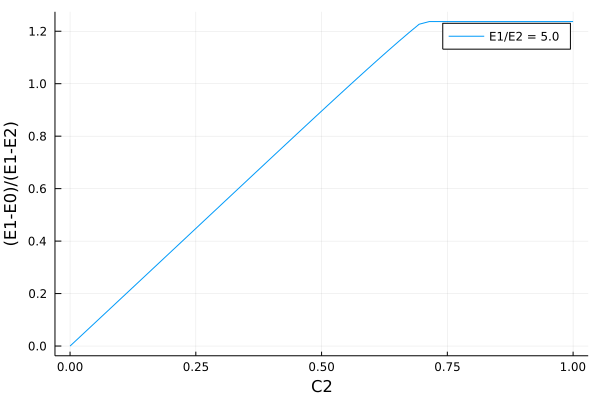

In [13]:
E1 = E_from_KG(K1, G1)
E2 = E_from_KG(K2, G2)
plot(Cs, (E1 .- E0s)./(E1-E2) , label="E1/E2 = $(round(E1/E2))", xaxis="C2", yaxis="(E1-E0)/(E1-E2)")

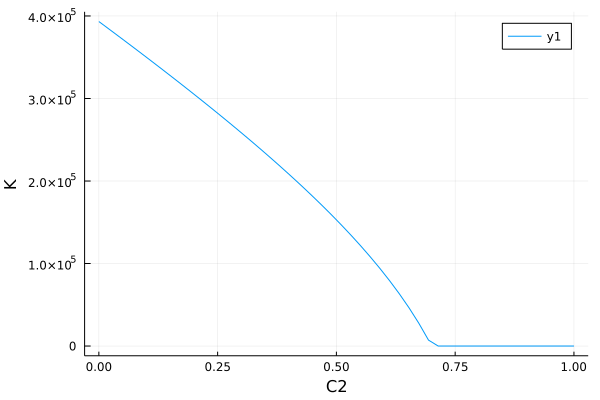

In [14]:
plot(Cs, Ks, xaxis="C2", yaxis="K")

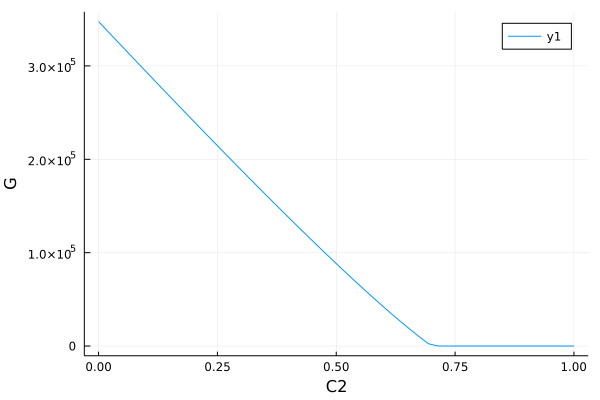

In [15]:
plot(Cs, Gs, xaxis="C2", yaxis="G")

# Disk-shaped

In [26]:
function G0_solver(K1, G1, K2, G2, C2, K0)
    return function(G0)
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        G0_innards = 2/(1+A) + 1 + (2 + (2-4*R/3)*A + 2*(3-4*R)*B)/(1+A+(3-4*R)*B)
        right_side = 1/G1 * (1 + C2/5 * G0_innards * (G1 - G2)/G0)
        return 1/G0 - right_side # =0 for correct G0
    end 
end

function K0_solver(K1, G1, K2, G2, C2)
    return function(K0)
        # Given a K0, G0 is uniquely defined 
        G0s = find_zeros(G0_solver(K1, G1, K2, G2, C2, K0), min(G1, G2), max(G1, G2))
        if length(G0s) != 1
            println("$(length(G0s)) Gs found for K0=$K0")
            return NaN
        end
        G0 = G0s[1]
        
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        right_side = (1/K1)*(1+C2/3* (3+4*R*A)/(1+A+(3-4*R)*B) * (K1-K2)/K0) # eq 23
        return 1/K0 - right_side
    end
end


function disk_inclusions(K1, G1, K2, G2, C2)

    K0s = find_zeros(K0_solver(K1, G1, K2, G2, C2), min(K1, K2), max(K1, K2))
    if length(K0s) != 1
            error("$(length(K0s)) Gs found")
    end
    
    # Now that have K0, find G0
    G0s = find_zeros(G0_solver(K1, G1, K2, G2, C2, K0s[1]), min(G1, G2), max(G1, G2))
    if length(G0s) != 1
            error("$(length(G0s)) Gs found")
    end
    
    return K0s[1], G0s[1]
end

disk_inclusions (generic function with 1 method)

In [27]:
myf = G0_solver(K1, G1, K2, G2, C2, K1)
find_zeros(myf, 10, 10000)

Float64[]

In [28]:
n = 60
Cs = collect(LinRange(0,1,n))
Ks = fill(NaN, n)
Gs = fill(NaN, n);
E0s = fill(NaN, n);

for i in 1:n
    Ks[i], Gs[i] = disk_inclusions(K1, G1, K2, G2, Cs[i])
    E0s[i] = E_from_KG(Ks[i], Gs[i])
end

0 Gs found for K0=120000.0
0 Gs found for K0=120000.00000000003
0 Gs found for K0=120000.00000000009
0 Gs found for K0=120000.00000000019
0 Gs found for K0=120000.00000000041
0 Gs found for K0=120000.00000000083
0 Gs found for K0=120000.00000000169
0 Gs found for K0=120000.00000000339
0 Gs found for K0=120000.0000000068
0 Gs found for K0=120000.00000001362
0 Gs found for K0=120000.00000002727
0 Gs found for K0=120000.00000005456
0 Gs found for K0=120000.00000010912
0 Gs found for K0=120000.00000021826
0 Gs found for K0=120000.00000043654
0 Gs found for K0=120000.0000008731
0 Gs found for K0=120000.00000174622
0 Gs found for K0=120000.00000349245
0 Gs found for K0=120000.0000069849
0 Gs found for K0=120000.00001396982
0 Gs found for K0=120000.00002793966
0 Gs found for K0=120000.00005587934
0 Gs found for K0=120000.0001117587
0 Gs found for K0=120000.0002235174
0 Gs found for K0=120000.00044703482
0 Gs found for K0=120000.00089406966
0 Gs found for K0=120000.00178813933
0 Gs found for K

LoadError: 0 Gs found

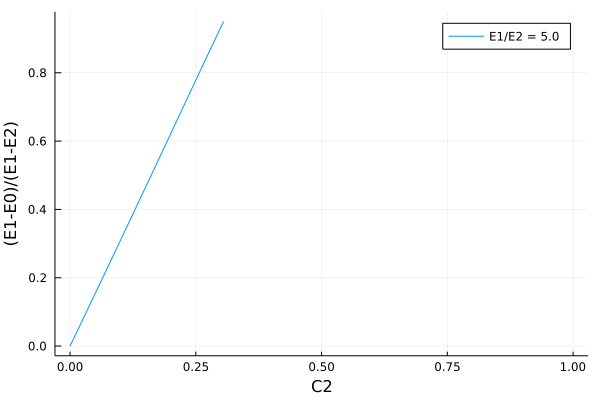

In [19]:
E1 = E_from_KG(K1, G1)
E2 = E_from_KG(K2, G2)
plot(Cs, (E1 .- E0s)./(E1-E2) , label="E1/E2 = $(round(E1/E2))", xaxis="C2", yaxis="(E1-E0)/(E1-E2)")

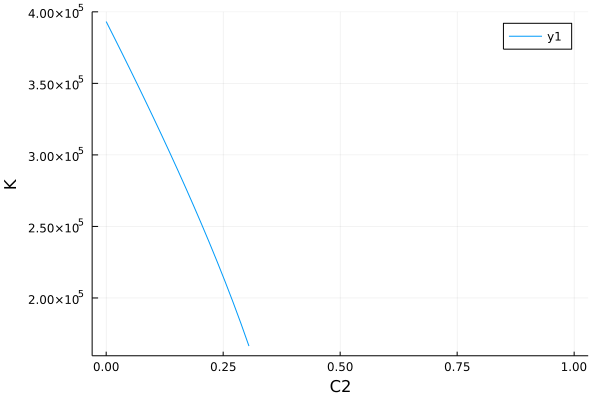

In [20]:
plot(Cs, Ks, xaxis="C2", yaxis="K")

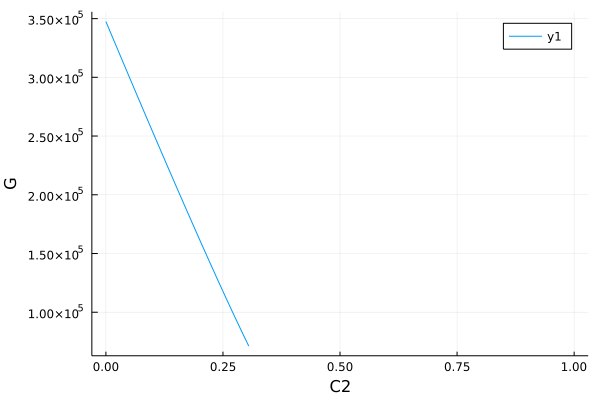

In [21]:
plot(Cs, Gs, xaxis="C2", yaxis="G")

In [22]:
min(1,2)

1

# Sphere shaped

In [23]:
function G0_solver(K1, G1, K2, G2, C2, K0)
    return function(G0)
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        # Eq 26
        G0_innards = C2/(1 + (1-4*R/3)*(A/5))
        right_side = 1/G1 * (1 + G0_innards * (G1-G2)/G0)
        return 1/G0 - right_side # =0 for correct G0
    end 
end

function K0_solver(K1, G1, K2, G2, C2)
    return function(K0)
        # Given a K0, G0 is uniquely defined 
        G0s = find_zeros(G0_solver(K1, G1, K2, G2, C2, K0), min(G1, G2), max(G1, G2))
        if length(G0s) != 1
            error("$(length(G0s)) Gs found for K0=$K0")
        end
        G0 = G0s[1]
        
        A = G2/G1 - 1
        B = 1/3*(K2/K1 - G2/G1)
        R = 3*G0/(3*K0 + 4*G0)
        
        right_side = (1/K1)*(1+ C2/(1+(1-4*R/3)*(A+3*B)) * (K1-K2)/K0) # eq 25
        return 1/K0 - right_side
    end
end


function sphere_inclusions(K1, G1, K2, G2, C2)

    K0s = find_zeros(K0_solver(K1, G1, K2, G2, C2), min(K1, K2), max(K1, K2))
    if length(K0s) != 1
            error("$(length(K0s)) Gs found")
    end
    
    # Now that have K0, find G0
    G0s = find_zeros(G0_solver(K1, G1, K2, G2, C2, K0s[1]), min(G1, G2), max(G1, G2))
    if length(G0s) != 1
            error("$(length(G0s)) Gs found")
    end
    
    return K0s[1], G0s[1]
end

sphere_inclusions (generic function with 1 method)

In [24]:
n = 60
Cs = collect(LinRange(0,1,n))
Ks = fill(NaN, n)
Gs = fill(NaN, n);
E0s = fill(NaN, n);

for i in 1:n
    Ks[i], Gs[i] = disk_inclusions(K1, G1, K2, G2, Cs[i])
    E0s[i] = E_from_KG(Ks[i], Gs[i])
end

LoadError: 0 Gs found

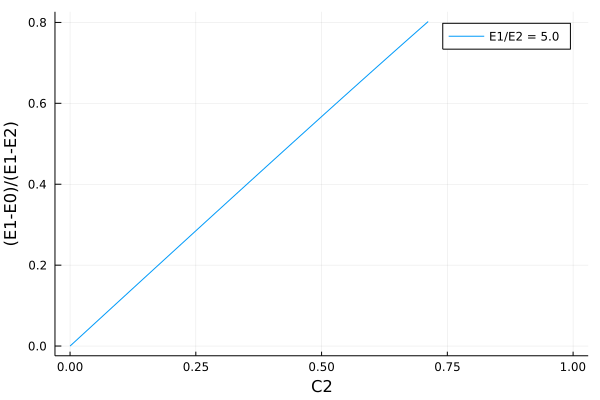

In [25]:
E1 = E_from_KG(K1, G1)
E2 = E_from_KG(K2, G2)
plot(Cs, (E1 .- E0s)./(E1-E2) , label="E1/E2 = $(round(E1/E2))", xaxis="C2", yaxis="(E1-E0)/(E1-E2)")